# Libraries

In [147]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline
from matplotlib.ticker import PercentFormatter
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report

contacts_file = ("contacts.tsv")
contacts = pd.read_csv(contacts_file, sep="\t")

searches_file = ("searches.tsv")
searches = pd.read_csv(searches_file, sep="\t")

In [148]:
def add_weekdays_column(df):
        """
        Adds a column 'weekdays' to the dataframe which lists the weekdays between check-in and check-out dates.
        """

        # Convert date columns to datetime objects
        df['ds_checkin'] = pd.to_datetime(df['ds_checkin'], errors='coerce')
        df['ds_checkout'] = pd.to_datetime(df['ds_checkout'], errors='coerce')

        # Function to calculate list of weekdays
        def get_weekdays(row):
            if pd.isnull(row['ds_checkin']) or pd.isnull(row['ds_checkout']):
                return None
            day_list = []
            current_day = row['ds_checkin']
            while current_day < row['ds_checkout']:
                day_list.append(current_day.strftime('%A'))
                current_day += timedelta(days=1)
            return day_list

        # Apply function to each row
        df['weekdays'] = df.apply(get_weekdays, axis=1)
        return df

def p_B_given_A(df, column_B, column_A):
    """
    Calculate the conditional probability of B being True given A is True.

    Parameters:
    df (pd.DataFrame): DataFrame containing the boolean columns.
    column_A (str): Column name for A.
    column_B (str): Column name for B.

    Returns:
    float: Conditional probability P(B | A).
    """
    # Ensure columns exist in DataFrame
    if column_A not in df.columns or column_B not in df.columns:
        raise ValueError("One or both specified columns do not exist in the DataFrame.")

    # Count the number of true values in column A
    count_A = df[column_A].sum()

    # Count the number of rows where both A and B are true
    count_A_and_B = df[df[column_A] & df[column_B]].shape[0]

    # Calculate conditional probability P(B | A)
    if count_A == 0:
        return None  # To handle the case where P(A) is 0, hence P(B | A) is undefined
    conditional_probability = count_A_and_B / count_A

    return conditional_probability

def plot_numeric_frequency(df, column_name):
    """
    Plots a vertical bar chart of numeric value frequencies sorted by the numeric values,
    with controlled labeling on both axes, without grid lines.

    Parameters:
    - df: Pandas DataFrame containing the numeric data.
    - column_name: String specifying the column with numeric values.

    Assumes the column specified by column_name contains float or integer data.
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Count the frequency of each unique value
    frequency = df[column_name].value_counts()

    # Sort the index (numeric values) in ascending order to plot by value
    sorted_by_value = frequency.sort_index()

    # Plotting
    plt.figure(figsize=(10, 6))  # Setting the figure size
    bars = plt.bar(sorted_by_value.index.astype(str), sorted_by_value.values, color='skyblue')
    plt.ylabel('Frequency')
    plt.xlabel('Numeric Values')
    plt.title(f'Frequency of Numeric Values in {column_name}')

    # Customizing x-axis labels to prevent overcrowding
    labels = sorted_by_value.index.astype(str)
    step = max(1, len(labels) // 10)  # Show a label every 10% of the total number of labels or at least 1
    plt.xticks(ticks=range(len(labels)), labels=[label if i % step == 0 else '' for i, label in enumerate(labels)], rotation=45)

    # Ensuring y-axis labels are integers
    max_freq = sorted_by_value.values.max()
    plt.yticks(range(0, max_freq + 1, max(1, max_freq // 10)))  # Adjust step for y-ticks based on max frequency

    plt.show()
def process_contacts(contacts):
  contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
  contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
  contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
  contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
  contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
  contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
  contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']
  contacts['accepted'] = contacts['ts_accepted_at'].notna()
  contacts['booked'] = contacts['ts_booking_at'].notna()

def plot_histogram(df, column_name, sort_desc=False):
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Error: The column '{column_name}' does not exist in the DataFrame.")
        return

    # Extract the column values
    data = df[column_name]

    # Count frequencies
    value_counts = data.value_counts()

    # Sort the value counts if sorting is requested
    if sort_desc:
        value_counts = value_counts.sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar' if sort_desc else 'hist', color='blue', edgecolor='black')

    plt.title(f'Histogram of {column_name}' + (' (Sorted)' if sort_desc else ''))
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    # Display the plot
    plt.show()

def plot_length_stay_frequency(df, column_name):
    """
    Plots a vertical bar chart of timedelta frequencies sorted by the number of days,
    with controlled labeling on both axes, without grid lines.

    Parameters:
    - df: Pandas DataFrame containing the timedelta data.
    - column_name: String specifying the column with timedelta values.

    Assumes the column specified by column_name contains timedelta64 data.
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Count the frequency of each unique duration
    frequency = df[column_name].value_counts()

    # Sort the index (timedelta) in ascending order to plot by number of days
    sorted_by_days = frequency.sort_index()

    # Plotting
    plt.figure(figsize=(10, 6))  # Setting the figure size
    bars = plt.bar(sorted_by_days.index.astype(str), sorted_by_days.values, color='skyblue')
    plt.ylabel('Frequency')
    plt.xlabel('Number of Days')
    plt.title(f'Frequency of Days Durations in {column_name}')

    # Customizing x-axis labels to prevent overcrowding
    labels = sorted_by_days.index.astype(str)
    step = max(1, len(labels) // 10)  # Show a label every 10% of the total number of labels or at least 1
    plt.xticks(ticks=range(len(labels)), labels=[label if i % step == 0 else '' for i, label in enumerate(labels)], rotation=45)

    # Ensuring y-axis labels are integers
    max_freq = sorted_by_days.values.max()
    plt.yticks(range(0, max_freq + 1, max(1, max_freq // 10)))  # Adjust step for y-ticks based on max frequency

    plt.show()

def plot_weekdays_hist(df):
        all_weekdays = []
        for weekdays in df['weekdays'].dropna():
            all_weekdays.extend(weekdays)

        # Count the frequency of each weekday
        weekday_counts = pd.Series(all_weekdays).value_counts()

        # Sort by the day of the week starting from Monday
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_counts = weekday_counts.reindex(weekday_order, fill_value=0)

        # Plotting the histogram
        plt.figure(figsize=(10, 6))
        weekday_counts.plot(kind='bar', color='skyblue')
        plt.title('Frequency of Weekdays in Bookings')
        plt.xlabel('Weekday')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        return

def calculate_supply_gap(df_supply, df_demand, smooth_factor=7, start_date=None, end_date=None,plot_supply=True,plot_demand=True,plot_gap=True,plot_reccomend=False):
    def count_days(df):
        date_series = df.apply(lambda row: pd.date_range(start=row['ds_checkin'], end=row['ds_checkout'] - pd.Timedelta(days=1), freq='D'), axis=1)
        all_dates = pd.Series([date for sublist in date_series for date in sublist])
        return all_dates.value_counts().sort_index()

    # Count days in both dataframes
    supply_count = count_days(df_supply)
    demand_count = count_days(df_demand)

    # Define the full date range from data or use the specified date range
    full_date_range = pd.date_range(start=min(supply_count.index.min(), demand_count.index.min()),
                                    end=max(supply_count.index.max(), demand_count.index.max()))
    supply_count = supply_count.reindex(full_date_range, fill_value=0)
    demand_count = demand_count.reindex(full_date_range, fill_value=0)

    # Limit data to the specified date range if provided
    if start_date and end_date:
        date_range = pd.date_range(start=start_date, end=end_date)
        supply_count = supply_count.reindex(date_range, fill_value=0)
        demand_count = demand_count.reindex(date_range, fill_value=0)

    # Apply a moving average to smooth the data, according to the smooth_factor
    smoothed_supply = supply_count.rolling(window=smooth_factor, min_periods=1).mean()
    smoothed_demand = demand_count.rolling(window=smooth_factor, min_periods=1).mean()

    gap = smoothed_demand - smoothed_supply

    # Calculate the percentage increase needed, scaled by the relative demand
    percent_increase_needed = (gap / smoothed_supply.where(smoothed_supply > 0)).replace([float('inf'), -float('inf')], pd.NA)
    percent_increase_needed *= (smoothed_demand / smoothed_demand.max()) * 100
    percent_increase_needed = percent_increase_needed.fillna(0)  # Replace NaNs with 0 where supply was sufficient or no demand
    plot_supply,plot_demand,plot_gap,plot_reccomend = True,True,True,True
    # Plotting
    plt.figure(figsize=(15, 7))
    if plot_supply:
      plt.plot(smoothed_supply.index, smoothed_supply, label='Supply (Smoothed)', color='blue', alpha=1.0)
    if plot_demand:
      plt.plot(smoothed_demand.index, smoothed_demand, label='Demand (Smoothed)', color='red', alpha=1.0)
    if plot_gap:
      plt.plot(gap.index, gap, label='Gap (Smoothed)', color='orange', alpha=1.0)
    if plot_reccomend:
      if not percent_increase_needed.isna().all():  # Check if there's any non-NaN value
          plt.plot(percent_increase_needed.index, percent_increase_needed, label='Recommended % Price Increase (Smoothed)', color='green')
          plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Setting y-axis formatter to display percentages
    plt.title(f'Recomended Price Increase Based on Supply Gap')
    plt.xlabel('Date')
    plt.ylabel('Count / Scaled Percentage')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return percent_increase_needed

def plot_bookings_by_month(df, date_column):
        """
        Plot the number of bookings by month from the specified date column in a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame containing the booking data.
        date_column (str): The column name that contains the date data.
        """
        print("NOTICE ")
        # Convert the specified column to datetime format, if not already
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

        # Drop rows where the date is NaT (not a time, i.e., missing or invalid dates)
        df = df.dropna(subset=[date_column])

        # Extract year and month from the date
        df['YearMonth'] = df[date_column].dt.to_period('M')

        # Count the number of bookings per month
        monthly_counts = df['YearMonth'].value_counts().sort_index()

        # Plot the data
        plt.figure(figsize=(12, 6))
        monthly_counts.plot(kind='bar', color='teal')
        plt.title('Number of Bookings by Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Bookings')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.show()
        return

def preprocess_datetime_columns(df, columns):
    """
    Converts specified columns of a DataFrame to datetime objects.
    """
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def add_booking_status_and_length_stay(df):
    """
    Adds booking status and calculates the length of stay for each entry in the DataFrame.
    """
    df['length_stay'] = df['ds_checkout'] - df['ds_checkin']
    df['accepted'] = df['ts_accepted_at'].notna()
    df['booked'] = df['ts_booking_at'].notna()
    return df

def remove_duplicates_and_filter_by_length(df, max_length_days=35, max_guests=6, max_messages=42):
    """
    Removes duplicates based on guest ID, filters entries by length of stay, number of guests,
    and number of messages.
    """
    df = remove_duplicates_keep_booking(df, 'id_guest')
    df = df[df['length_stay'] <= np.timedelta64(max_length_days, 'D')]
    df = df[df['n_guests'] <= max_guests]
    df = df[df['n_messages'] <= max_messages]
    return df

def preprocess_searches(df):
    """
    Drops unnecessary columns and filters searches based on maximum price and number of nights.
    """
    df = df.drop(columns=['filter_neighborhoods'], errors='ignore')
    df = df[df['filter_price_max'] <= 600]
    df = df[df['n_nights'] < 20]
    return df
'''
def clip_all(contacts=None, searches=None):
    """
    Processes and clips contact and search dataframes based on specified criteria.
    """
    # Process contact data
    datetime_columns_contacts = ['ts_contact_at', 'ts_reply_at', 'ts_accepted_at', 'ts_booking_at', 'ds_checkin', 'ds_checkout']
    contacts = preprocess_datetime_columns(contacts, datetime_columns_contacts)
    contacts = add_weekdays_column(contacts)
    contacts = add_booking_status_and_length_stay(contacts)
    contacts = remove_duplicates_and_filter_by_length(contacts)

    # Process search data
    datetime_columns_searches = ['ds']
    searches = preprocess_datetime_columns(searches, datetime_columns_searches)
    searches = add_weekdays_column(searches)
    searches['length_preparation'] = searches['ds_checkin'] - searches['ds']
    searches = preprocess_searches(searches)

    return contacts, searches
'''

def clip_all(contacts = None,searches = None):

  contacts = add_weekdays_column(contacts)
  contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
  contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
  contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
  contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
  contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
  contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
  contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']
  contacts['accepted'] = contacts['ts_accepted_at'].notna()
  contacts['booked'] = contacts['ts_booking_at'].notna()
  #filter to requests under 35 days
  removed_dupe_guests = remove_duplicates_keep_booking(contacts,'id_guest')
  td = np.timedelta64(35,'D')
  filtered_contacts = removed_dupe_guests[removed_dupe_guests['length_stay'] <= td]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts)) * 100
  #print(f"{1 - round(percentage_true,2)}% of the cropped outliers were booked")
  #plot_length_stay_frequency(filtered_contacts,'length_stay')
  max_guest_clip = 6
  filtered_contacts = filtered_contacts[filtered_contacts['n_guests'] <= max_guest_clip]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts['booked'])) * 100
  percentage_true = 1 - round(percentage_true,2)
  #print(f"{percentage_true}% of the cropped outliers were booked")
  max_messages_clip = 42
  filtered_contacts = filtered_contacts[filtered_contacts['n_messages'] <= max_messages_clip]
  percentage_true = (filtered_contacts['booked'].sum() / len(filtered_contacts['booked'])) * 100
  percentage_true = 1 - round(percentage_true,2)
  #print(f"{percentage_true}% of the cropped outliers were booked")
  #plot_length_stay_frequency(filtered_contacts,'length_stay')

  #CLIP SEARCHES


  #Drop filter_neighborhoods column
  #MAYBE DONT USE THIS?
  searches['ds'] = pd.to_datetime(searches['ds'])
  searches = add_weekdays_column(searches)
  searches['length_preperation'] = searches['ds_checkin'] - searches['ds']
  searches = searches.drop(columns=['filter_neighborhoods'])
  filtered_searches = searches[searches['filter_price_max'] <= 600]
  #plot_numeric_frequency(filtered_searches,'filter_price_max')

  #Remove n_nights beyond 20 days
  filtered_searches = filtered_searches[filtered_searches['n_nights'] < 20]

  return filtered_contacts, filtered_searches

def remove_duplicates_keep_booking(df, label_column):
    """
    Removes duplicates while prioritizing rows where booking is true.
    """
    df_sorted = df.sort_values(by=['booked', label_column], ascending=[False, True])
    return df_sorted.drop_duplicates(subset=[label_column], keep='first')

def describe_skew(df):
  display(df.describe())
  display(df.skew(axis = 0, numeric_only = True, skipna = True))

def report_missing_data(df):
    """
    Reports the total number of entries and the number and percentage of missing values for each column in a DataFrame.
    """
    print('Total Number of Entries:', len(df))
    print("Total and Percent of Null Values:")
    print(f"{'Column':<20} {'Total Nulls':>15} {'Percent Nulls':>15}")

    for column in df.columns:
        total_nulls = df[column].isna().sum()
        percent_nulls = (total_nulls / len(df)) * 100
        if total_nulls != 0:
            print(f"{column:<20} {total_nulls:>15,} {percent_nulls:>14.2f}%")
def show_booking_rates(df):
  print(f"Probability of booking given the inquirie was accepted {round(p_B_given_A(df,'booked','accepted'),2)*100}%")
  print(f"Probability of booking given the inquirie was accepted {round(p_B_given_A(df,'booked','accepted'),2)*100}%")




In [149]:
report_missing_data(searches)
describe_skew(searches)

Total Number of Entries: 35737
Total and Percent of Null Values:
Column                   Total Nulls   Percent Nulls
ds_checkin                    11,849          33.16%
ds_checkout                   11,849          33.16%
n_nights                      11,849          33.16%
filter_price_min              22,415          62.72%
filter_price_max              22,415          62.72%
filter_room_types             19,546          54.69%
filter_neighborhoods          34,391          96.23%


,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max
count,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04
mean,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07
std,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08
min,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00
25%,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01
50%,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02
75%,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02
max,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09


n_searches           7.509258
n_nights             9.942364
n_guests_min         3.583798
n_guests_max         3.148548
filter_price_min    11.087745
filter_price_max     2.999833
dtype: float64

In [150]:
report_missing_data(contacts)
describe_skew(contacts)

Total Number of Entries: 7823
Total and Percent of Null Values:
Column                   Total Nulls   Percent Nulls
ts_reply_at                      604           7.72%
ts_accepted_at                 4,196          53.64%
ts_booking_at                  5,649          72.21%


,n_guests,n_messages
count,7823.000000,7823.000000
mean,2.422600,6.319954
std,1.617347,6.472827
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,4.000000
75%,3.000000,8.000000
max,16.000000,102.000000


n_guests      2.441468
n_messages    3.696440
dtype: float64

In [151]:
filtered = process_contacts(contacts)
filtered = remove_duplicates_keep_booking(contacts,'id_guest')
report_missing_data(filtered)
describe_skew(filtered)

Total Number of Entries: 3283
Total and Percent of Null Values:
Column                   Total Nulls   Percent Nulls
ts_reply_at                      147           4.48%
ts_accepted_at                   942          28.69%
ts_booking_at                  1,241          37.80%


,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,length_stay
count,3283,3136,2341,2042,3283,3283,3283.000000,3283.000000,3283
mean,2014-10-11 05:32:29.392628736,2014-10-11 15:55:57.763074048,2014-10-12 14:51:35.520290304,2014-10-13 10:43:35.279138048,2014-11-16 11:20:18.275967232,2014-11-21 11:55:49.984770048,2.482790,9.435882,5 days 00:35:31.708802924
min,2014-03-04 11:08:13,2014-04-18 09:39:06,2014-05-21 16:51:54,2014-05-21 16:51:54,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,1.000000,1 days 00:00:00
25%,2014-10-04 09:54:22.500000,2014-10-04 15:43:21.500000,2014-10-05 05:34:55,2014-10-05 14:03:57,2014-10-16 00:00:00,2014-10-19 00:00:00,1.000000,4.000000,2 days 00:00:00
50%,2014-10-08 23:02:44,2014-10-09 11:20:32,2014-10-09 18:53:16,2014-10-10 10:47:40.500000,2014-10-31 00:00:00,2014-11-04 00:00:00,2.000000,7.000000,3 days 00:00:00
75%,2014-10-14 06:51:03.500000,2014-10-14 12:34:19.500000,2014-10-14 19:47:48,2014-10-15 13:16:17.249999872,2014-11-21 00:00:00,2014-11-28 00:00:00,3.000000,13.000000,4 days 00:00:00
max,2015-01-29 14:30:18,2015-01-29 15:14:47,2015-02-03 14:16:42,2015-01-21 16:16:29,2015-10-24 00:00:00,2015-10-31 00:00:00,16.000000,102.000000,245 days 00:00:00
std,NaN,NaN,NaN,NaN,NaN,NaN,1.757701,8.034797,11 days 03:21:05.413737767


n_guests      2.680656
n_messages    2.687486
accepted     -0.942519
booked       -0.503405
dtype: float64

From this we can see that less than 30% of contacts lead to bookings if we include multiple contacts from the same guest user. Making it appear that demand far exceeds supply. However, this is misleading.

In [152]:
#Show the skew for successful bookings
booked = contacts[contacts['booked'] == True].copy()
describe_skew(booked)

,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,length_stay
count,2174,2174,2174,2174,2174,2174,2174.000000,2174.000000,2174
mean,2014-10-12 08:29:32.132474624,2014-10-12 12:34:46.316007168,2014-10-12 18:34:02.882244608,2014-10-13 07:54:43.307267840,2014-11-13 01:15:30.634774528,2014-11-16 15:49:50.616375296,2.295308,12.616835,3 days 14:34:19.981600736
min,2014-05-21 16:45:43,2014-05-21 16:51:32,2014-05-21 16:51:54,2014-05-21 16:51:54,2014-10-01 00:00:00,2014-10-03 00:00:00,1.000000,2.000000,1 days 00:00:00
25%,2014-10-04 20:18:26.750000128,2014-10-05 00:38:23.249999872,2014-10-05 10:01:22,2014-10-05 13:53:46,2014-10-16 00:00:00,2014-10-19 00:00:00,1.000000,7.000000,2 days 00:00:00
50%,2014-10-09 16:07:28.500000,2014-10-09 18:23:29,2014-10-09 21:08:38.500000,2014-10-10 11:15:13,2014-10-31 00:00:00,2014-11-03 00:00:00,2.000000,11.000000,3 days 00:00:00
75%,2014-10-14 17:16:40.750000128,2014-10-14 19:20:13.249999872,2014-10-14 21:35:28.500000,2014-10-15 13:16:17.249999872,2014-11-17 00:00:00,2014-11-22 00:00:00,3.000000,16.000000,4 days 00:00:00
max,2015-01-20 23:58:11,2015-01-21 16:16:29,2015-01-21 16:16:29,2015-01-21 16:16:29,2015-10-21 00:00:00,2015-10-24 00:00:00,13.000000,102.000000,98 days 00:00:00
std,NaN,NaN,NaN,NaN,NaN,NaN,1.405140,8.197960,4 days 08:54:41.552761169


n_guests      2.005456
n_messages    2.849698
accepted      0.000000
booked        0.000000
dtype: float64

In [153]:
#Remove outlires
contacts, searchs = clip_all(contacts,searches)

In [154]:
#New Skew and display stats after removing outliers in Contacts
report_missing_data(contacts)
describe_skew(contacts)
show_booking_rates(contacts)

Total Number of Entries: 3126
Total and Percent of Null Values:
Column                   Total Nulls   Percent Nulls
ts_reply_at                      138           4.41%
ts_accepted_at                   860          27.51%
ts_booking_at                  1,131          36.18%


,ts_contact_at,ts_reply_at,ts_accepted_at,ts_booking_at,ds_checkin,ds_checkout,n_guests,n_messages,length_stay
count,3126,2988,2266,1995,3126,3126,3126.000000,3126.000000,3126
mean,2014-10-11 04:01:17.452655104,2014-10-11 13:44:58.673360128,2014-10-12 10:00:17.168579072,2014-10-13 06:25:08.821052416,2014-11-14 04:33:37.658349312,2014-11-18 03:02:52.744721664,2.293986,9.348369,3 days 22:29:15.086372360
min,2014-03-04 11:08:13,2014-05-21 16:51:32,2014-05-21 16:51:54,2014-05-21 16:51:54,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,1.000000,1 days 00:00:00
25%,2014-10-04 09:07:58.249999872,2014-10-04 15:04:55.500000,2014-10-04 23:13:14.750000128,2014-10-05 13:40:01,2014-10-15 00:00:00,2014-10-19 00:00:00,1.000000,4.000000,2 days 00:00:00
50%,2014-10-08 22:00:22,2014-10-09 10:32:44,2014-10-09 17:08:24.500000,2014-10-10 09:32:49,2014-10-30 00:00:00,2014-11-02 00:00:00,2.000000,7.500000,3 days 00:00:00
75%,2014-10-14 03:31:54,2014-10-14 12:14:03.750000128,2014-10-14 18:40:53.500000,2014-10-15 10:15:54,2014-11-17 00:00:00,2014-11-23 00:00:00,3.000000,13.000000,4 days 00:00:00
max,2015-01-29 14:30:18,2015-01-29 15:14:47,2015-01-28 22:57:47,2015-01-21 16:16:29,2015-10-21 00:00:00,2015-10-24 00:00:00,6.000000,42.000000,35 days 00:00:00
std,NaN,NaN,NaN,NaN,NaN,NaN,1.268300,7.176799,4 days 13:17:13.641987718


n_guests      1.188447
n_messages    1.410255
accepted     -1.007661
booked       -0.575466
dtype: float64

Probability of booking given the inquirie was accepted 88.0%
Probability of booking given the inquirie was accepted 88.0%


In [155]:
#New Skew and display stats after removing outliers in searches
report_missing_data(searches)
describe_skew(searches)

Total Number of Entries: 35737
Total and Percent of Null Values:
Column                   Total Nulls   Percent Nulls
ds_checkin                    11,849          33.16%
ds_checkout                   11,849          33.16%
n_nights                      11,849          33.16%
filter_price_min              22,415          62.72%
filter_price_max              22,415          62.72%
filter_room_types             19,546          54.69%
filter_neighborhoods          34,391          96.23%
weekdays                      11,849          33.16%
length_preperation            11,849          33.16%


,ds,ds_checkin,ds_checkout,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max,length_preperation
count,35737,23888,23888,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04,23888
mean,2014-10-07 14:32:34.478551552,2014-11-27 22:42:10.609511168,2014-12-05 14:50:57.468184832,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07,51 days 08:11:53.730743469
min,2014-10-01 00:00:00,2014-10-01 00:00:00,2014-10-02 00:00:00,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00,-1 days +00:00:00
25%,2014-10-04 00:00:00,2014-10-17 00:00:00,2014-10-23 00:00:00,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01,10 days 00:00:00
50%,2014-10-08 00:00:00,2014-11-03 00:00:00,2014-11-09 00:00:00,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02,26 days 00:00:00
75%,2014-10-11 00:00:00,2014-12-13 00:00:00,2014-12-24 00:00:00,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02,67 days 00:00:00
max,2014-10-14 00:00:00,2016-06-02 00:00:00,2016-08-17 00:00:00,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09,604 days 00:00:00
std,NaN,NaN,NaN,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08,65 days 18:56:19.491940518


n_searches           7.509258
n_nights             9.942364
n_guests_min         3.583798
n_guests_max         3.148548
filter_price_min    11.087745
filter_price_max     2.999833
dtype: float64

Show supply, demand, supply gap, and a reccomened price increase based on the formula Price = Original Price  * (demand/supply)

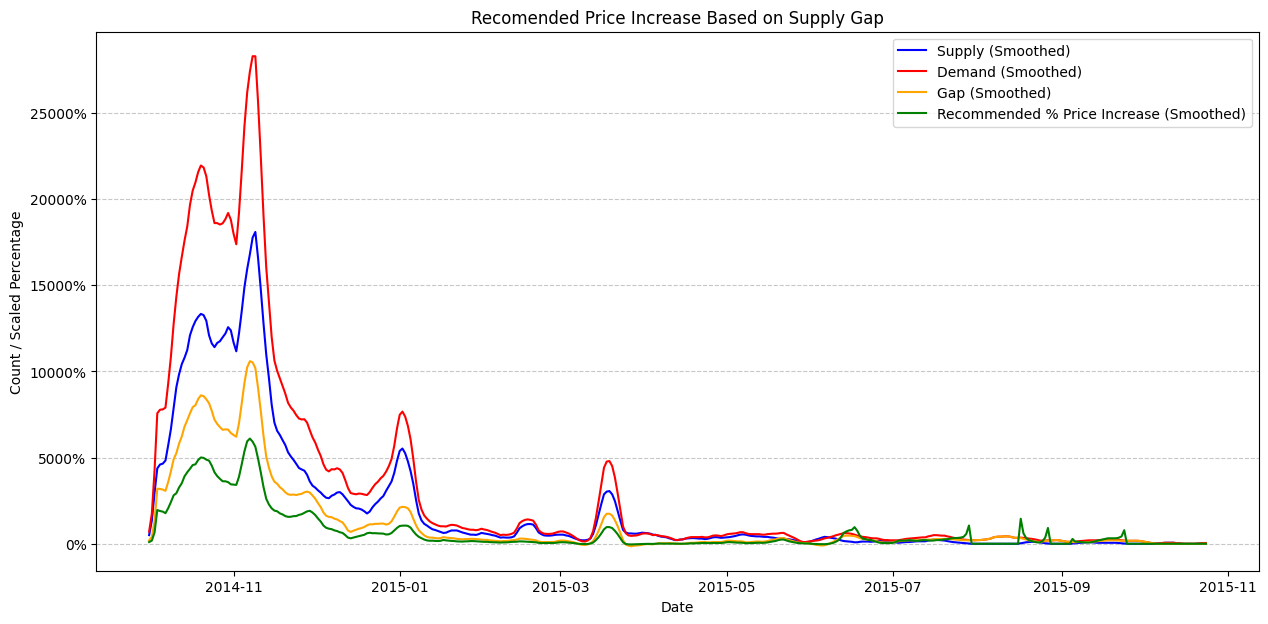

In [156]:
percent_increase = calculate_supply_gap(booked, contacts, smooth_factor=7, start_date='2014-10-01', end_date='2015-10-24')

In [160]:
#plot_weekdays_hist(contacts)

In [ ]:
#plot_bookings_by_month(contacts)

In [ ]:
#plot_weekdays_hist(searches)

In [ ]:
#plot_bookings_by_month(searches)